# In this note book we will analyze the transeverse field Ising model (TFIM)

The many-body spin Hamiltnonian in 1-d is given by:

$$ \mathcal{H}= -(1-t)\sum_{i}\sigma^z_i\sigma^z_{i+1}-t\sum_i \sigma^x_i $$

This is an exactly solvable model, the sollution can be found in the second chapter of <a href="https://arxiv.org/pdf/0904.2771.pdf">this lecture note</a>.

For the limit $t=0$, this has a ferromagnetic (FM) ground state (GS) with two fold degeneracy, which spontaneously breaks the global $Z_2$ symmetry of the Hamiltonian. In the limit $t=1$, the GS is unique (called paramagetic, i.e. PM) and doesn't break any symmetry.

In this notebook we will do the following things:

* <a href='#building_ham'>Construct the many-body Hamiltonian matrix, without any symmetry (e.g. translation or $Z_2$)</a>
* <a href='#diagonalization'>Diagonalize the matrix to obtain few low energy eigenstate.</a>
* <a href='#gap'>Follwoing the GS and few excitated state we will find the quantum phase transition (QPT) point, which is well known ($t=.5$) in the community.</a>
* <a href='#ss_scaling'>System size scaling to understand the QPT.</a>
* Find out the correlation functions (in future)

In [1]:
# basic python operations
import numpy as np

# scientific coputing
from functools import reduce
import scipy.sparse as sps
import scipy.sparse.linalg as spslin
from scipy.optimize import curve_fit

# visualization
import matplotlib.pyplot as plt

In [2]:
# Loading the Pauli matrices

Id = sps.eye(2)
Sx = sps.csr_matrix(np.array([[0,1.+0.j],[1+0.j,0]]))
Sy = sps.csr_matrix(np.array([[0,-1.j],[1.j,0]]))
Sz = sps.csr_matrix(np.array([[1+0.j,0.],[0,-1+0.j]]))

## Building the many-body Hamiltonian <a id='building_ham'></a>

In [3]:
def ham_general(L,static):
    ham_gen=np.zeros(shape=(2**L,2**L),dtype=np.complex)
    for item in static:
        string=item[0]
        for inside in item[1:len(item)]:
            for j in range(len(inside)):
                op_list=[Id]*L
                for k in range(len(string)):
                    if string[k]=='x':
                        op_list[inside[j][k+1]]=Sx
                    elif string[k]=='y':
                        op_list[inside[j][k+1]]=Sy
                    elif string[k]=='z':
                        op_list[inside[j][k+1]]=Sz
                #print(reduce(sps.kron,op_list).toarray())
                ham_gen += inside[j][0]*reduce(sps.kron,op_list).toarray()
    #            
    return ham_gen

Now as we are ready to diagonalize the Hamiltonian, first we will do a small test, to check if everything is OK.

In [4]:
L=6
g=-.001
J=-1.
x_field=[[g,i] for i in range(L)]
J_nn=[[J,i,(i+1)%L] for i in range(L)]

static=[["zz",J_nn],["x",x_field]]

(e2,u) = spslin.eigsh(ham_general(L,static), k=8, which='SA',return_eigenvectors=True)

e2

array([-6.0000015 , -6.0000015 , -2.0034651 , -2.00300075, -2.002     ,
       -2.00300075, -2.0017323 , -2.0017323 ])

For a large Ising ($\sigma^z\sigma^z$) interaction w.r.t. a small field ($\sigma^x$), we get closely space two GS and the first excited state with an excitation gap $\Delta\sim 4$. Which is as expected. Now we will run the code for many system sizes and parameter regime ($t$).

## Diagonalizing TFIM <a id='diagonalization'></a> 

In [5]:
L_arr=np.arange(4,11,2)
t_arr=np.linspace(0,1,21)
evalu=8

energy=np.ndarray(shape=(len(t_arr),len(L_arr),evalu))
for j in range(len(t_arr)):
    for k in range(len(L_arr)):
        L=L_arr[k]
        ## defining the parameter
        g=-t_arr[j]
        J=-(1-t_arr[j])
        ## making the adjacent matrix
        x_field=[[g,i] for i in range(L)]
        J_nn=[[J,i,(i+1)%L] for i in range(L)]
        static=[["zz",J_nn],["x",x_field]]
        ## diagonalization of the Hamiltonian
        (e2,u) = spslin.eigsh(ham_general(L,static), k=evalu, which='SA',return_eigenvectors=True)
        energy[j,k,:]=np.sort(e2)

In [6]:
gap=np.ndarray(shape=(len(t_arr),len(L_arr),evalu))

for j in range(len(t_arr)):
    for k in range(len(L_arr)):
        gap[j,k,:]=energy[j,k,:]-energy[j,k,0]

## Understanding the data <a id='gap'></a> 

Now that we have diagonalized the Hamiltonian, we will try to understand the data by cleaning it. Bellow, the first and the second excited gaps are plotted for all the valuse of $t$, we should expect that fot $t\sim 0$, we have a two fold degenerate FM GS with the excitation gap $\Delta\sim 4$ and, for $t\sim 1$ a single PM ground state with spin flip excitation $\Delta \sim 2$.

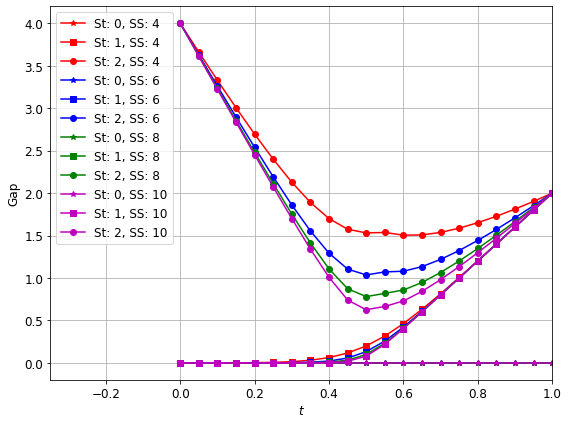

In [7]:
ms,fs=6,12

plt.figure(figsize=(8,6))
plt.xlim(-.35,1)
color=['r','b','g','m','y','c','k']
marker=['*','s','o','v','^','x',]
for j in range(len(L_arr)):
    for k in range(3):
        plt.plot(t_arr,gap[:,j,k],'%s%s-'%(color[j],marker[k]),markersize=ms,label='St: %d, SS: %d'%(k,L_arr[j]))
plt.ylabel('Gap',fontsize=fs)
plt.xlabel('$t$',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(fontsize=fs)
plt.grid()
plt.tight_layout()
plt.show()

Clearly for different system sizes we are getting the result as expected. From this plot it is also clear that, the two fold degeneracy of the GS in the FM limit is going away aroud $t\sim .5$, we will try to sharpen this understanding.

To do this, we notice that, in the exactly solvable limit $t=0,1$, the results are independent of the system size but for $t\in (0,1)$, it is system size dependent. Particularly notice that the second gap (circular marker) is varying a lot, w.r.t the system size.

We can do a system size scaling to remove the dependecy.

## System size scaling <a id='ss_scaling'></a> 


The gap in a finite size varies as $$\Delta^{j}(L)=m^{j}\frac{1}{L}+\Delta^{j}_{\infty}$$

We can plot the $\Delta^{j}$ vs $1/L$ for the different system size available, to get the $\Delta^{j}_{\infty}$. Here $j$ is index of the $j^{th}$ gap. This is called the tower of state in the literature.

In [8]:
def lin_fit(x,m,c):
    return m*x+c

intercept=np.ndarray(shape=(len(t_arr),2))
var_int=np.ndarray(shape=(len(t_arr),2))

m=np.ndarray(shape=(len(t_arr),2))
var_m=np.ndarray(shape=(len(t_arr),2))

for j in range(len(t_arr)):
    for k in range(2):
        popt,pcov=curve_fit(lin_fit,1./L_arr,gap[j,:,k+1],bounds=([-np.inf,0],np.inf))
        intercept[j,k],var_int[j,k]=popt[1],pcov[1,1]
        m[j,k],var_m[j,k]=popt[0],pcov[0,0]

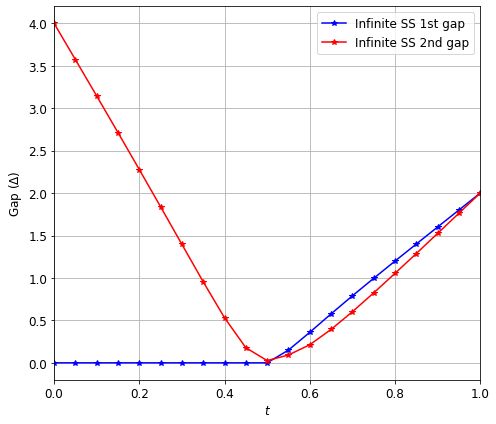

In [9]:
ms,fs=6,12

plt.figure(figsize=(7,6))
plt.xlim(0,1)
plt.plot(t_arr,intercept[:,0],'b*-',markersize=ms,label='Infinite SS 1st gap')
plt.plot(t_arr,intercept[:,1],'r*-',markersize=ms,label='Infinite SS 2nd gap')
plt.xlabel('$t$',fontsize=fs)
plt.ylabel('Gap ($\Delta$)',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(loc='best',fontsize=fs)
plt.grid()
plt.tight_layout()
plt.show()

Now from the above plot it is pretty much clear that the first gap in the FM limit is nothing but the other degenerate GS, which goes to spin flip excited state in the PM limit. But the second gap is finite in th both the exact limit $t=0,1$, which comes down to zero at $t=.5$, i.e. the quantum phase transition point.

Furthermore we can visualize the quality of the linear fit for the system size scaling.

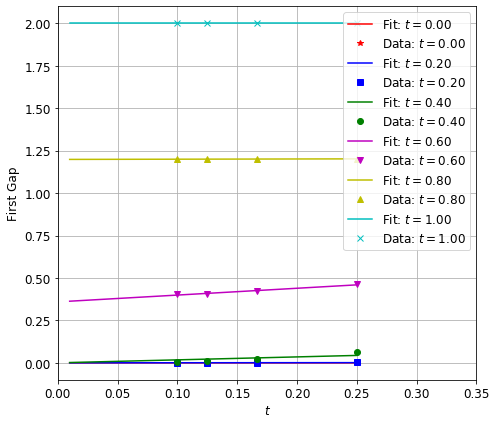

In [10]:
newL_arr=np.arange(4,101,16)

plt.figure(figsize=(7,6))
plt.xlim(0,.35)
color=['r','b','g','m','y','c','k']
marker=['*','s','o','v','^','x',]

for j in range(0,len(t_arr),4):
    y_arr=lin_fit((1./newL_arr),m[j,0],intercept[j,0])
    plt.plot((1./newL_arr),y_arr,'-',color=color[j//4],label='Fit: $t=$%.2f'%(t_arr[j]))
    plt.plot((1./L_arr),gap[j,:,1],'%s'%(marker[j//4]),color=color[j//4],label='Data: $t=$%.2f'%(t_arr[j]))
    
plt.xlabel('$t$',fontsize=fs)
plt.ylabel('First Gap',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(loc='best',fontsize=fs)
plt.grid()
plt.tight_layout()
plt.show()

In the above plot notice that starting from $t=0$ untill $t=.4$, the first gap $\Delta^{1}_{\infty}$ is close to zero, while it becomes finite and exactly $\Delta^{1}_{\infty}=2$ in the PM limit.

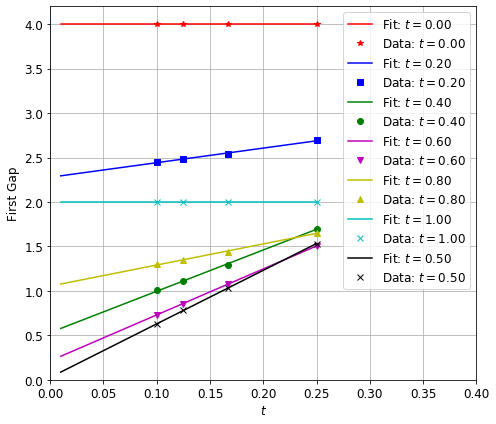

In [11]:
plt.figure(figsize=(7,6))
plt.xlim(0,.4)
plt.ylim(0,4.2)
color=['r','b','g','m','y','c','k']
marker=['*','s','o','v','^','x',]

for j in range(0,len(t_arr),4):
    y_arr=lin_fit((1./newL_arr),m[j,1],intercept[j,1])
    plt.plot((1./newL_arr),y_arr,'-',color=color[j//4],label='Fit: $t=$%.2f'%(t_arr[j]))
    plt.plot((1./L_arr),gap[j,:,2],'%s'%(marker[j//4]),color=color[j//4],label='Data: $t=$%.2f'%(t_arr[j]))

j=10
y_arr=lin_fit((1./newL_arr),m[j,1],intercept[j,1])
plt.plot((1./newL_arr),y_arr,'-',color='k',label='Fit: $t=$%.2f'%(t_arr[j]))
plt.plot((1./L_arr),gap[j,:,2],'%s'%('x'),color='k',label='Data: $t=$%.2f'%(t_arr[j]))
    
plt.xlabel('$t$',fontsize=fs)
plt.ylabel('First Gap',fontsize=fs)
plt.xticks(fontsize=fs)
plt.yticks(fontsize=fs)
plt.legend(loc='upper right',fontsize=fs)
plt.grid()
plt.tight_layout()
plt.show()

In summary, in python it is very easy to solve a quantum many-body problem. In an updated version of the current file I will talk about the correlation function for this model.